<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x36_%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E7%9A%84%E7%AE%80%E6%B4%81%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

本节将使用PyTorch来更简洁地实现基于循环神经网络的语言模型。首先，我们读取周杰伦专辑歌词数据集。

In [3]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import math
import numpy as np
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning/')
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

Mounted at /content/drive
Wed Feb 24 03:16:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## 1.定义模型
PyTorch中的nn模块提供了循环神经网络的实现。下面构造一个含单隐藏层、隐藏单元个数为256的循环神经网络层rnn_layer。

In [4]:
num_hiddens = 256
rnn_layer = nn.RNN(input_size = vocab_size,hidden_size=num_hiddens)

与上一节中实现的循环神经网络不同，这里rnn_layer的输入形状为(时间步数, 批量大小, 输入个数)。其中输入个数即one-hot向量长度（词典大小）。此外，rnn_layer作为nn.RNN实例，在前向计算后会分别返回输出和隐藏状态h，其中输出指的是隐藏层在各个时间步上计算并输出的隐藏状态，它们通常作为后续输出层的输入。需要强调的是，该“输出”本身并不涉及输出层计算，形状为(时间步数, 批量大小, 隐藏单元个数)。而nn.RNN实例在前向计算返回的隐藏状态指的是隐藏层在最后时间步的隐藏状态：当隐藏层有多层时，每一层的隐藏状态都会记录在该变量中；对于像长短期记忆（LSTM），隐藏状态是一个元组(h, c)，即hidden state和cell state。我们会在本章的后面介绍长短期记忆和深度循环神经网络。关于循环神经网络（以LSTM为例）的输出，可以参考下图

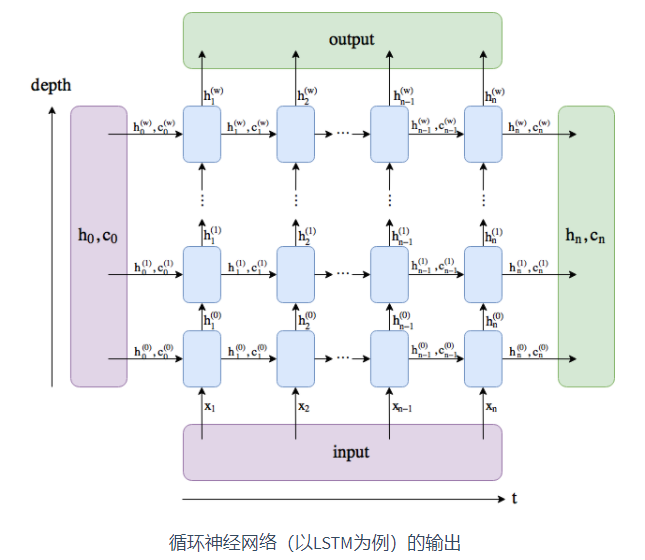

来看看我们的例子，输出形状为(时间步数, 批量大小, 隐藏单元个数)，隐藏状态h的形状为(层数, 批量大小, 隐藏单元个数)。

In [5]:
num_steps = 256
batch_size = 2
state = None
X = torch.rand(num_steps,batch_size,vocab_size)
Y,state_new = rnn_layer(X,state)
print(Y.shape,len(state_new),state_new[0].shape)

torch.Size([256, 2, 256]) 1 torch.Size([2, 256])


如果rnn_layer是nn.LSTM实例，那么上面的输出是什么？

接下来我们继承Module类来定义一个完整的循环神经网络。它首先将输入数据使用one-hot向量表示后输入到rnn_layer中，然后使用全连接输出层得到输出。输出个数等于词典大小vocab_size。

In [6]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer,vocab_size):
        super(RNNModel,self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size*(2 if rnn_layer.bidirectional else 1)
        self.vocab_size = vocab_size
        self.dense = nn.Linear(self.hidden_size,vocab_size)
        self.state = None
    
    def forward(self,inputs,state): # inputs: (batch, seq_len)
        # 获取one_hot向量表示
        X = d2l.to_onehot(inputs,vocab_size)
        Y,self.state = self.rnn(torch.stack(X),state)
        # 全连接层会首先将Y的形状变成(num_steps * batch_size, num_hiddens)，它的输出
        # 形状为(num_steps * batch_size, vocab_size)
        output = self.dense(Y.view(-1,Y.shape[-1]))
        return output,self.state

## 2.训练模型


In [7]:
def predict_rnn_pytorch(prefix,num_chars,model,vocab_size,device,idx_to_char,char_to_idx):
    state=None
    output = [char_to_idx[prefix[0]]]  # output会记录prefix加上输出
    for t in range(num_chars + len(prefix) -1):
        X = torch.tensor([output[-1]],device=device).view(1,1)
        if state is not None:
            if isinstance(state,tuple):# LSTM, state:(h, c)  
                state = (state[0].to(device),state[1].to(device))
            else:
                state = state.to(device)
        (Y,state) = model(X,state)
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y.argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [8]:
# 让我们使用权重为随机值的模型来预测一次
model = RNNModel(rnn_layer,vocab_size).to(device)
predict_rnn_pytorch('分开',10,model,vocab_size,device,idx_to_char,char_to_idx)

'分开祷担引慢币养糗朽卷呢'

接下来实现训练函数。算法同上一节的一样，但这里只使用了相邻采样来读取数据。

In [13]:
def train_and_predict_rnn_pytorch(model,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,num_epochs,num_steps,lr,clipping_thena,
                    batch_size,pred_period,pred_len,prefixes):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    model.to(device)
    state = None
    for epoch in range(num_epochs):
        l_sum,n,start = 0.0,0,time.time()
        data_iter = d2l.data_iter_consecutive(corpus_indices,batch_size,num_steps,device)
        for X,Y in data_iter:
            if state is not None:
                # 使用detach函数从计算图分离隐藏状态, 这是为了
                # 使模型参数的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                if isinstance(state,tuple): # LSTM, state:(h, c)  
                    state = (state[0].detach(),state[1].detach())
                else:
                    state = state.detach()
            
            # output: 形状为(num_steps * batch_size, vocab_size)
            (output,state) = model(X,state)
            
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # batch_size * num_steps 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y,0,1).contiguous().view(-1)
            l = loss(output,y.long())

            optimizer.zero_grad()
            l.backward()
            # 梯度裁剪
            d2l.grad_clipping(model.parameters(),clipping_thena,device)
            optimizer.step()
            l_sum += l.item()*y.shape[0]
            n += y.shape[0]

        try:
            perplexity  = math.exp(l_sum/n)
        except OverflowError:
            perplexity  = float('inf')
        
        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, perplexity, time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_pytorch(
                    prefix, pred_len, model, vocab_size, device, idx_to_char,
                    char_to_idx))


In [14]:
num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e-3, 1e-2 # 注意这里的学习率设置
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)


epoch 50, perplexity 28.546548, time 0.03 sec
 - 分开 我不你 我不你的可爱 我 我不我 我不在 我不  想要你 想要 我想你 一爱女人 坏不的让我疯狂的
 - 不分开 我不你 我 我不不你 我 你的我  你的你 我 我想不你 我不我 我不你 一不 我 我 我不我 我
epoch 100, perplexity 6.872604, time 0.03 sec
 - 分开 我不 我不我 不不我不不不不 不不 我不不不不不 我想要你想你你 我不你 想不你 想你你想想你 想
 - 不分开  不不再想  想要你 不不 我不你 想不你 想你你想想你 想要你 想要你想要你 想不你 不不 我不
epoch 150, perplexity 2.515889, time 0.03 sec
 - 分开 我不要再想我 我不能 我不能再想不你 爱不不 爱不  爱过 一切戏 语乡心碎的永远 道的是很  天
 - 不分开我 我不能你 不能不能不觉 我不再我不我不不不能不不不不不 不要再想不你不要再 不想我 不想你你已经
epoch 200, perplexity 1.514148, time 0.03 sec
 - 分开的让我感动的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 
 - 不分开不 我不休 爱你我一定会我想要你 经过去 我不知道你 让我不想你你已经我 不想你我不你 想想你想不你
epoch 250, perplexity 1.212525, time 0.03 sec
 - 分开的一个戏 还是 是你是一场悲剧 我想就这辈子注定一个人演戏 最后再一个人慢慢的回忆 没有你烦我 我有
 - 不分开不 太多 我不要再想是 不要走 是你已经多过我 想要 这样打我妈妈 难道你手 你说啊 你想一直到步三
